# MASCARA ESPACIO PERIVASCULAR

In [3]:
import SimpleITK as sitk

import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt


image_viewer = sitk.ImageViewer()

In [4]:
import pydicom as pyd

## Funciones

In [5]:
def histo(img, itkIm = True):
    if itkIm:
        arr = sitk.GetArrayFromImage(img)
    else:
        arr = img
    fig = plt.figure(figsize = (7,5))
    ax = fig.gca()
    ax.hist(arr.flatten(), bins = 255)
    plt.show(fig)

def plotImg(mg, color = 'gray'):
    arr = sitk.GetArrayFromImage(img)
    plt.imshow(arr, cmap = color)

In [6]:
from varname import nameof

def newFileName(var1, var2):
    '''
    Create a string with the name of two variables
    
    Parameters
    ----------
    var1 (could be any variable)
    var2 (could be any variable)
    
    Returns
    -------
    fileName (string): name of this two variables together.
    '''
    fileName = nameof(var1) + '_' + nameof(var2) + '.nrrd'
    return fileName

# Cargar datos

In [8]:
# fiji = 'D:/Users/maryskal/Slicer 5.0.2/Slicer.exe'
slicer = '/home/maryskal/Slicer/Slicer'
image_viewer.SetApplication(slicer)
ctFolder = 'Vessel_stencils'

### Separar arterias y venas

In [9]:
def separar(mask):
    # vemos los valores diferentes que existen
    arr = sitk.GetArrayFromImage(mask)
    values = np.unique(arr)
    values = values[values != 0]
    
    # sacamos una mascara por cada valor
    masks = []
    for value in values:
        masks.append(mask == value)

    return masks

### Cargar
En un paciente cargar sus mascaras, la total y la de arterias y venas

In [10]:
def paciente(ctPath: str, maskPaths: list):
    pacienteDict = {}
    pacienteDict['path'] = ctPath
    pacienteDict['ct'] = sitk.ReadImage(ctPath)
    for i, path in enumerate(maskPaths):
        vesselMask = sitk.ReadImage(path)
        pacienteDict['vessel_' + str(i)] = vesselMask
        sep = separar(vesselMask)
        pacienteDict['vessel_A_' + str(i)] = sep[0]
        pacienteDict['vessel_B_' + str(i)] = sep[1]
    pacienteDict['n_vessels'] = len(maskPaths)

    return pacienteDict

In [8]:
ctPath = os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD.nrrd')
maskPaths = [os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD_stenciledVesselLabelMap_full.nrrd'),
             os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD_stenciledVesselLabelMap_CSA_lt5.nrrd'),
             os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD_stenciledVesselLabelMap_CSA_gt20.nrrd')]

In [9]:
pacienteData = paciente(ctPath, maskPaths)

In [10]:
pacienteData.keys()

dict_keys(['path', 'ct', 'vessel_0', 'vessel_A_0', 'vessel_B_0', 'vessel_1', 'vessel_A_1', 'vessel_B_1', 'vessel_2', 'vessel_A_2', 'vessel_B_2', 'n_vessels'])

## TC

In [11]:
ct = pacienteData['ct']

In [12]:
image_viewer.Execute(ct)

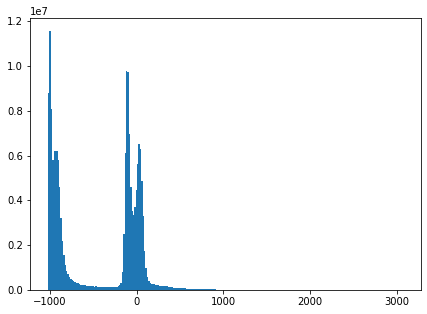

In [13]:
histo(ct)

## Mascaras de vaso

***Mascara todos los vasos***

In [14]:
generalMask = pacienteData['vessel_0']

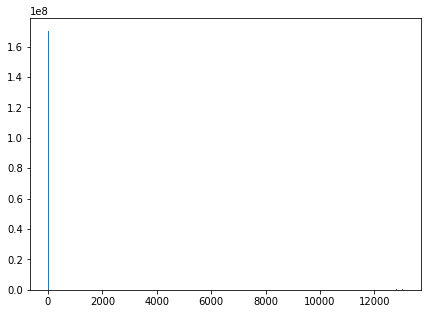

In [15]:
histo(generalMask)

***Mascara vasos 5 mm***

In [16]:
mask5 = pacienteData['vessel_1']

In [17]:
image_viewer.Execute(mask5)

***Mascara vasos 20 mm***

In [18]:
mask20 = pacienteData['vessel_2']

# Mapa de distancias a las mascaras

## Mascara general

Hago la matriz de distancias sobre la mascara

In [19]:
allDistances = sitk.SignedMaurerDistanceMap(generalMask, 
                                    insideIsPositive = False, 
                                    squaredDistance = False,
                                    useImageSpacing=True)

In [97]:
# allDistancesD = sitk.SignedDanielssonDistanceMap(generalMask, 
#                                     insideIsPositive = False, 
#                                     squaredDistance = False,
#                                     useImageSpacing=True)

In [190]:
allDistances.GetPixelIDTypeAsString()

'32-bit float'

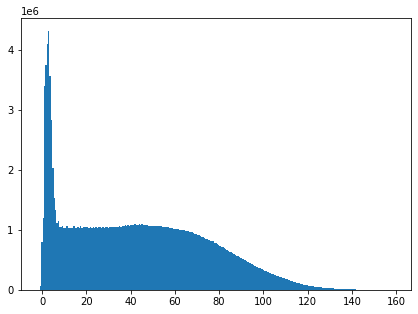

In [84]:
histo(allDistances)

#### Espacio perivascular de 3 mm

In [187]:
distance3 = allDistances > 0 and allDistances < 3

In [191]:
distance3.GetPixelIDTypeAsString()

'8-bit unsigned integer'

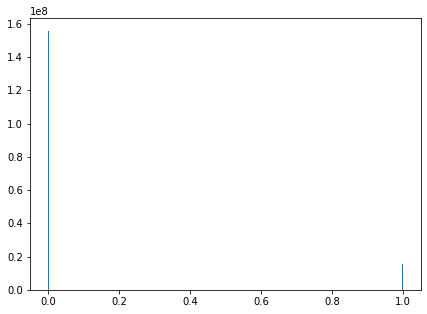

In [48]:
histo(distance3)

Para mostrarlo lo multiplico por 3000 porque sino el 1 el programa lo muestra como negro

In [14]:
image_viewer.Execute(distance3*3000)

No se porque se queda tambien con lo de dentro del vaso, asi que voy a tener que eliminarlo.

In [196]:
def eliminarVaso(distance, mask):
    # Hago el cast porque si no son del mismo tipo no me deja restar
    new = sitk.Cast(distance, sitk.sitkUInt16) - mask
    return new

In [197]:
distance3 = eliminarVaso(distance3, generalMask)

In [32]:
image_viewer.Execute(distance3*3000)

Vemos que ahora el vaso ya no se coge con la máscara.

Vamos a aplicar la mascara sobre el TC

In [54]:
def extractMask(ct, mask):
    ct = sitk.GetArrayFromImage(ct)
    mask = sitk.GetArrayFromImage(mask)
    ct[mask == 0] = 0
    return sitk.GetImageFromArray(ct)

In [55]:
ct3 = extractMask(ct, distance3)

In [56]:
image_viewer.Execute(ct3)

## Comprobar los resultados negativos

Mauler

In [98]:
ar = sitk.GetArrayFromImage(allDistances)
ar = ar[ar<1]

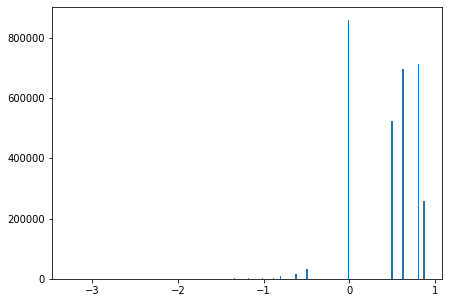

In [99]:
histo(ar, False)

Daniel

In [100]:
ar = sitk.GetArrayFromImage(allDistancesD)
ar = ar[ar<1]

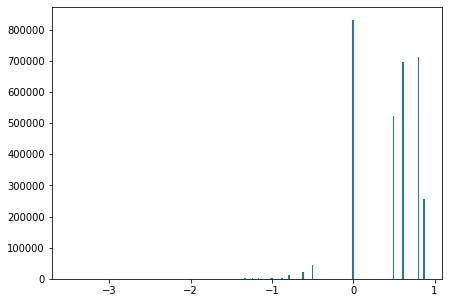

In [101]:
histo(ar, False)

Solo vasos grandes

In [102]:
grandesVasos = generalMask - mask20

In [106]:
image_viewer.Execute(grandesVasos)

In [103]:
allDistances = sitk.SignedMaurerDistanceMap(grandesVasos, 
                                    insideIsPositive = False, 
                                    squaredDistance = False,
                                    useImageSpacing=True)

In [104]:
ar = sitk.GetArrayFromImage(allDistancesD)
ar = ar[ar<1]

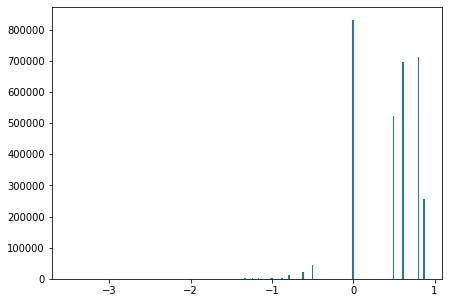

In [105]:
histo(ar, False)

# AUTOMATIZAR EL PROCESO

In [20]:
import logging
import sys

# Configura el logging
log_format = '[%(process)d]\t%(asctime)s %(levelname)s: %(message)s'
logging.basicConfig(format=log_format, level=logging.INFO, datefmt="%H:%M:%S",
                    handlers=[logging.StreamHandler(sys.stdout)])

In [72]:
def eliminarVaso(distance, remove):
    '''
    Eliminate a vesel mask from a perivascular mask 
    
    Parameters
    ----------
    distance (sitk Image): perivascular distance mask
    mask (sitk Image): vascular mask
    
    Returns
    -------
    sitk image without vesels.
    '''
    # A las distancias le restamos la otra mascara binarizada
    new = distance - sitk.BinaryThreshold(remove, 1, 100000, 1)
    
    # Binarizamos el resultado para que no queden valores negativos
    new = sitk.BinaryThreshold(new, 1,1,1)
    
    logging.info('[F]\teliminarVaso() executed')

    return new

In [64]:
def saveMask(image, path, fileName):
    '''
    Save a sitk Image
    
    Parameters
    ----------
    image (sitk Image): image to save
    path (string): where to save
    fileName (string): name for saving
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    sitk.WriteImage(image, os.path.join(path,fileName))
    
    logging.info('[F]\tsaveMask executed in {}, as {}'.format(path, fileName))

In [65]:
def createDistanceMask(vessels, distance, remove, save = False, filename = 'mask.nrrd', folder = 'Vessel_stencils/masks'):
    '''
    Create a perivascular mask from a vascular mask given a 
    distance in mm
    
    Parameters
    ----------
    vesels (sitk Image): vascular mask
    distance (double): distance in mm for de perivascular mask
    save (bool): if you want automatically save the mask
    folder (string): folder where image will be saved
    
    Returns
    -------
    sitk image of perivascular space.
    '''
    # Se crea el mapa de distancias
    allDistances = sitk.SignedMaurerDistanceMap(vessels, 
                                    insideIsPositive = False, 
                                    squaredDistance = False, 
                                    useImageSpacing=True)
    # Se crea la máscara con el espacio seleccionado
    distanceMask = allDistances > 0 and allDistances < distance
    # Se elimina el vaso de la máscara
    distanceMask = eliminarVaso(distanceMask, remove)
    
    if save:
        # Se guarda la mascara
        saveMask(distanceMask, folder, filename)
    
    logging.info('[F]\tcreateDistanceMaks executed, saved {}'.format(save))
    
    return distanceMask

### Todos los vasos automatico

Creo una funcion que guarda cada uno de las mascaras de vaso con cada una de las distancias.

In [29]:
# %load_ext line_profiler

Funcion con un for, sin hacer ni procesos ni hilos

In [66]:
def savePatientMask(patient, masks, distances, remove):
    '''
    If you introduce vascular masks and distances of a patient
    it create a new mask with each vascular mask and each distance
    and it save them in a folder with the name of the patient.
        
    Parameters
    ----------
    patient (string): name of the patient
    mask (list of sitk image): vascular mask
    distance (list of double): perivascular distance
    '''
    # Creo la carpeta de este paciente
    patientFolder = os.path.join('Vessel_stencils', patient)
    
    # Se recorre cada una de las mascaras vasculares
    # y se calcula cada una de las distancias
    for i, mask in enumerate(masks):
        for distance in distances:
            # Creo el nombre del file
            fileName = 'mask_' + str(i) + '_' + str(distance) + '.nrrd'
            # Creo la máscara
            createDistanceMask(mask, distance, remove, True, fileName, patientFolder)
            # Mando el aviso
            logging.info("[F]\tmask {} created".format(fileName))


    logging.info("[F]\tDONE!")


Funcion utilizando hilos y procesos

In [126]:
# from threading import Thread

# def savePatientMaskT(patient, masks, distances):
#     '''
#     If you introduce vascular masks and distances of a patient
#     it create a new mask with each vascular mask and each distance
#     and it save them in a folder with the name of the patient.
    
#     It uses threads to make it faster
    
#     Parameters
#     ----------
#     patient (string): name of the patient
#     mask (list of sitk image): vascular mask
#     distance (list of double): perivascular distance
#     '''
#     # Creo la carpeta de este paciente
#     patientFolder = os.path.join('Vessel_stencils', patient)
#     # Creo un vector de threads
#     threads = []
#     # Inicializo el numero de threads
#     tNumber = 0
    
#     # Se recorre cada una de las mascaras vasculares
#     # y se calcula cada una de las distancias
#     for i, mask in enumerate(masks):
#         for distance in distances:
#             # Creo el nombre del file
#             fileName = 'mask_' + str(i) + '_' + str(distance) + '.nrrd'
            
#             # Actualizo el numero de threads
#             tNumber +=1
            
#             # Inicio un thread con la funcion createDistanceMask
#             thread = Thread(target = createDistanceMask, 
#                     args = (mask, distance, True, fileName, patientFolder))
#             # Lo añado a la lista
#             threads.append(thread)
#             # Lo inicializo
#             thread.start()
#             # Imprimo el aviso
#             logging.info("[T]\tThread {} started!".format(tNumber))
    
#     # Espera a que los threads finalicen
#     for tNumber, thread in enumerate(threads):
#         thread.join()
#         logging.info("[T]\tThread {} joined!".format(tNumber))

#     logging.info("[T]\tDONE!")

In [127]:
from multiprocessing import Process

def savePatientMaskP(patient, masks, distances):
    '''
    If you introduce vascular masks and distances of a patient
    it create a new mask with each vascular mask and each distance
    and it save them in a folder with the name of the patient.
    
    It uses process to make it faster
    
    Parameters
    ----------
    patient (string): name of the patient
    mask (list of sitk image): vascular mask
    distance (list of double): perivascular distance
    '''
    # Creo la carpeta de este paciente
    patientFolder = os.path.join('Vessel_stencils', patient)
    # Creo un vector de threads
    proceses = []
    # Inicializo el numero de threads
    pNumber = 0
    
    # Se recorre cada una de las mascaras vasculares
    # y se calcula cada una de las distancias
    for i, mask in enumerate(masks):
        for distance in distances:
            # Creo el nombre del file
            fileName = 'mask_' + str(i) + '_' + str(distance) + '.nrrd'
            
            # Actualizo el numero de threads
            pNumber +=1
            
            # Inicio un thread con la funcion createDistanceMask
            process = Process(target = createDistanceMask, 
                    args = (mask, distance, True, fileName, patientFolder))
            # Lo añado a la lista
            proceses.append(process)
            # Lo inicializo
            process.start()
            # Imprimo el aviso
            logging.info("[T]\tThread {} started!".format(pNumber))
    
    # Espera a que los threads finalicen
    for pNumber, process in enumerate(proceses):
        process.join()
        logging.info("[T]\tThread {} joined!".format(pNumber))

    logging.info("[T]\tDONE!")

Compruebo cual es mas rapida de las tres

In [67]:
pacienteData.keys()

dict_keys(['path', 'ct', 'vessel_0', 'vessel_A_0', 'vessel_B_0', 'vessel_1', 'vessel_A_1', 'vessel_B_1', 'vessel_2', 'vessel_A_2', 'vessel_B_2', 'n_vessels'])

In [68]:
index = ['vessel_A_0', 'vessel_B_0', 'vessel_A_1', 'vessel_B_1', 'vessel_A_2', 'vessel_B_2']
masks = [pacienteData[i] for i in index]
distances = [2,3,5,10]

In [73]:
%%time
savePatientMask('pacientePrueba', masks, distances, pacienteData['vessel_0'])

[7208]	17:49:42 INFO: [F]	eliminarVaso() executed
[7208]	17:49:42 INFO: [F]	saveMask executed in Vessel_stencils\pacientePrueba, as mask_0_2.nrrd
[7208]	17:49:42 INFO: [F]	createDistanceMaks executed, saved True
[7208]	17:49:42 INFO: [F]	mask mask_0_2.nrrd created
[7208]	17:49:50 INFO: [F]	eliminarVaso() executed
[7208]	17:49:50 INFO: [F]	saveMask executed in Vessel_stencils\pacientePrueba, as mask_0_3.nrrd
[7208]	17:49:50 INFO: [F]	createDistanceMaks executed, saved True
[7208]	17:49:51 INFO: [F]	mask mask_0_3.nrrd created
[7208]	17:49:58 INFO: [F]	eliminarVaso() executed
[7208]	17:49:59 INFO: [F]	saveMask executed in Vessel_stencils\pacientePrueba, as mask_0_5.nrrd
[7208]	17:49:59 INFO: [F]	createDistanceMaks executed, saved True
[7208]	17:49:59 INFO: [F]	mask mask_0_5.nrrd created
[7208]	17:50:07 INFO: [F]	eliminarVaso() executed
[7208]	17:50:08 INFO: [F]	saveMask executed in Vessel_stencils\pacientePrueba, as mask_0_10.nrrd
[7208]	17:50:08 INFO: [F]	createDistanceMaks executed, sav

In [72]:
# %%time

# masks = [generalMask, mask5, mask20]
# distances = [2,3,5,10]

# savePatientMaskT('pacientePruebaT', masks, distances)

In [73]:
# %%time

# masks = [generalMask, mask5, mask20]
# distances = [2,3,5,10]

# savePatientMaskP('pacientePruebaP', masks, distances)

Compruebo que se han guardado correctamente y los cargo de nuevo

In [16]:
from os import listdir
from os.path import isfile, join

In [17]:
mypath = 'Vessel_stencils/masks'
# Recojo todos los files en mypath
masks = [f for f in listdir(mypath) if isfile(join(mypath, f))]

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'Vessel_stencils/masks'

In [37]:
data = [sitk.ReadImage(os.path.join(mypath, path)) for path in masks]

### Proceso uno por uno

##### Todos los vasos

In [38]:
distance2General = createDistanceMask(generalMask, 2)
distance3General = createDistanceMask(generalMask, 3)
distance5General = createDistanceMask(generalMask, 5)
distance10General = createDistanceMask(generalMask, 10)

[11644]	12:46:21 INFO: [F]	eliminarVaso() executed
[11644]	12:46:21 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:46:32 INFO: [F]	eliminarVaso() executed
[11644]	12:46:32 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:46:43 INFO: [F]	eliminarVaso() executed
[11644]	12:46:44 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:46:54 INFO: [F]	eliminarVaso() executed
[11644]	12:46:54 INFO: [F]	createDistanceMaks executed, saved False


##### Vasos de 20

In [39]:
distance2_20 = createDistanceMask(mask20, 2)
distance3_20 = createDistanceMask(mask20, 3)
distance5_20 = createDistanceMask(mask20, 5)
distance10_20 = createDistanceMask(mask20, 10)

[11644]	12:47:03 INFO: [F]	eliminarVaso() executed
[11644]	12:47:03 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:47:12 INFO: [F]	eliminarVaso() executed
[11644]	12:47:12 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:47:21 INFO: [F]	eliminarVaso() executed
[11644]	12:47:21 INFO: [F]	createDistanceMaks executed, saved False
[11644]	12:47:29 INFO: [F]	eliminarVaso() executed
[11644]	12:47:29 INFO: [F]	createDistanceMaks executed, saved False


##### Vasos de 5

In [39]:
distance2_5 = createDistanceMask(mask5, 2)
distance3_5 = createDistanceMask(mask5, 3)
distance5_5 = createDistanceMask(mask5, 5)
distance10_5 = createDistanceMask(mask5, 10)

NameError: name 'logging' is not defined

### Pruebas

In [41]:
image_viewer.Execute(distance10General*3000000)

In [42]:
pr = extractMask(ct, distance5_5)
image_viewer.Execute(pr)

In [43]:
distance2_5 = createDistanceMask(mask5, 2)

[11644]	12:48:28 INFO: [F]	eliminarVaso() executed
[11644]	12:48:28 INFO: [F]	createDistanceMaks executed, saved False


In [44]:
pr = extractMask(ct, distance2General)
image_viewer.Execute(pr)